In [1]:
!pip install sklearn
!pip install seaborn
!pip install scikit-fuzzy

  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post9-py3-none-any.whl size=2952 sha256=37a4f20e8dfde50194e2c99ffed830d22412bd0089d0c7c7fb8c80616102789a
  Stored in directory: /root/.cache/pip/wheels/33/a3/d2/092b519e9522b4c91608b7dcec0dd9051fa1bff4c45f4502d1
Successfully built sklearn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 21.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894079 sha256=20be224a5eb7404cad67c6fd9fc7d1621a43f0d3ff84e306be9f7a9175ba86ef
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import pairwise_distances
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn import preprocessing
import math

In [3]:
df = pd.read_csv('/content/input.csv')

In [4]:
df.drop(['Method Name','Package Name',"Impl Method Name",'Impl Package Name'],axis=1,inplace=True)


In [5]:
df.info()
df.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Class Name           109 non-null    object
 1   Class Annotation     108 non-null    object
 2   Impl Class Name      48 non-null     object
 3   Number of parameter  109 non-null    int64 
 4   Number of call       109 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 4.4+ KB


In [7]:
le1 = preprocessing.LabelEncoder()
le1.fit(df['Class Name'])
df['Class Name'] = list(le1.transform(df['Class Name'] ))

le2 = preprocessing.LabelEncoder()
le2.fit(df['Impl Class Name'])
df['Impl Class Name'] = list(le2.transform(df['Impl Class Name'] ))

le3 = preprocessing.LabelEncoder()
le3.fit(df['Class Annotation'])
df['Class Annotation'] = list(le3.transform(df['Class Annotation'] ))

In [10]:
df['Class Name'] = list(le1.inverse_transform(df['Class Name'] ))

df['Impl Class Name'] = list(le2.inverse_transform(df['Impl Class Name'] ))

df['Class Annotation'] = list(le3.inverse_transform(df['Class Annotation'] ))


In [11]:
new_df = df.drop(['Class Annotation','Number of parameter'],axis=1)


In [13]:
class_names = list(set(list(new_df['Class Name']) + list(new_df['Impl Class Name'])))

# Initialize an adjacency matrix with zeros
adj_matrix = pd.DataFrame(0,index=class_names, columns=class_names)
# Fill the adjacency matrix with number of calls as edge values
for _, row in new_df.iterrows():
    class_name = row['Class Name']
    impl_class_name = row['Impl Class Name']
    num_calls = row['Number of call']
    adj_matrix.at[class_name, impl_class_name] = int(num_calls)

#print(class_names)
adj_matrix.fillna(0,inplace=True)
# Display the adjacency matrix

adj_matrix.to_csv('/content/graph_mat.csv')

In [14]:
# Calculate Silhouette score,Calinski-Harabasz index and Davies-Bouldin index
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
def scores(matrix, clusters):
  silhouette_avg = silhouette_score(matrix, clusters)
  print("Silhouette Score:", silhouette_avg)

  # Calculate Calinski-Harabasz index
  ch_score = calinski_harabasz_score(matrix, clusters)
  print("Calinski-Harabasz Index:", ch_score)

  # Calculate Davies-Bouldin index
  db_score = davies_bouldin_score(matrix, clusters)
  print("Davies-Bouldin Index:", db_score)

Claculating distance matrix

In [15]:
adjacency_matrix = adj_matrix.to_numpy()

distance_matrix = 1 / (adjacency_matrix + 1)  # Adding 1 to avoid division by zero

Call Graph Visualisation

<ipython-input-16-004ffecdf7d0>:52: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar1 = plt.colorbar(sm1)


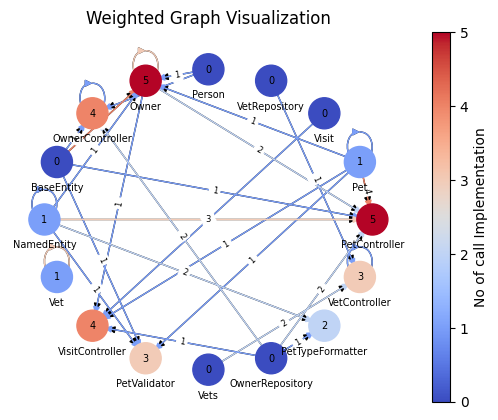

In [16]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib

# Create a graph from the adjacency matrix
G = nx.DiGraph()

num_nodes = adjacency_matrix.shape[0]

# Add nodes to the graph
G.add_nodes_from(range(num_nodes))

# Add edges with weights
for i in range(num_nodes):
    for j in range(num_nodes):
        weight = adjacency_matrix[i, j]
        if weight > 0:
            G.add_edge(i, j, weight=weight)

pos = nx.circular_layout(G)
# Get edge weights for color-coding
edge_weights = [data['weight'] for u, v, data in G.edges(data=True)]

# Create a colormap for edge colors based on weights
#cmap = plt.cm.get_cmap('viridis')
cmap = matplotlib.colormaps.get_cmap('coolwarm')

call_no = np.sum(np.where(adjacency_matrix>0,1,0),axis=0)
norm = plt.Normalize(vmin=min(call_no),vmax=max(call_no))

# Map normalized weights to colormap values
edge_colors = [cmap(norm(weight)) for weight in edge_weights]

# Map normalized weights to colormap values
node_colors = [cmap(norm(weight)) for weight in call_no]

node_label_positions = {k: [v[0], v[1] - 0.17] for k, v in pos.items()}

nx.draw_networkx_labels(G, node_label_positions, labels=dict(enumerate(adj_matrix.index)), font_size=7, font_color='black')
nx.draw_networkx_labels(G, pos, labels=dict(enumerate(call_no)), font_size=7, font_color='black')



# Draw the graph
nx.draw(G, pos, with_labels=False, node_size=500, font_size=5, font_color='black',node_color=node_colors)
edges = nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=1)

# Add colorbar
sm1 = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm1.set_array([])
cbar1 = plt.colorbar(sm1)
cbar1.set_label('No of call Implementation')


edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black',font_size=6)

plt.title("Weighted Graph Visualization")
plt.show()



## **Interdependence Strategy** - Spectral Clustering with k-means

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels: [1 1 0 0 0 1 2 1 1 0 0 0 0 2 0 0]
Silhouette Score: 0.4461393808668134
Calinski-Harabasz Index: 7.127328138160961
Davies-Bouldin Index: 0.8803976957358443


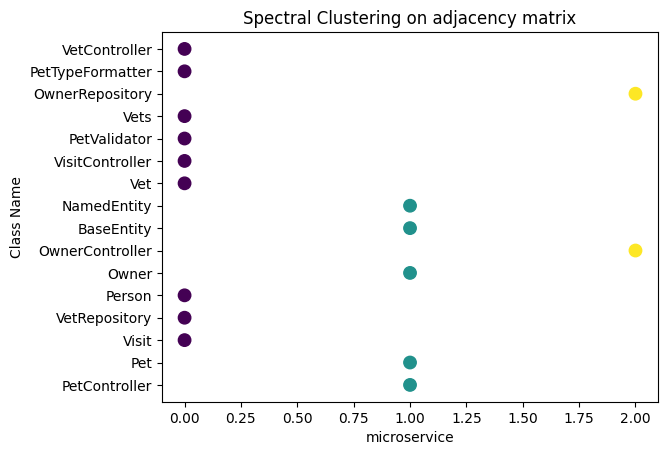

In [17]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize

# Construct the unnormalized graph Laplacian
degree_matrix = np.diag(np.sum(adjacency_matrix, axis=1))
laplacian_matrix = degree_matrix - adjacency_matrix

num_clusters = 6
# Calculate the frst few eigenvectors and normalize them
eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)
eigenvectors = eigenvectors[:, :num_clusters]
eigenvectors_norm = normalize(eigenvectors)


# Perform K-Means clustering on normalized eigenvectors
kmeans = KMeans(n_clusters=3)
cluster_labels = kmeans.fit_predict(eigenvectors_norm)

print("Cluster Labels:", cluster_labels)

# Evaluate the clustering
scores(eigenvectors_norm, cluster_labels)
#ari = adjusted_rand_score(true_labels, predicted_labels)

# Plot the results
plt.scatter(cluster_labels,adj_matrix.columns, c=cluster_labels, cmap='viridis', s=80)
plt.xlabel('microservice')
plt.ylabel('Class Name')
plt.title('Spectral Clustering on adjacency matrix')
plt.show()


Visualisation of eigen value and eigenvector

            v_0           v_1           v_2           v_3  v_4  v_5
0  9.722197e-01  2.222957e-01 -7.330397e-02  5.295695e-31  0.0  0.0
1  9.434199e-01  3.120358e-01 -1.122165e-01  3.052841e-30  0.0  0.0
2  0.000000e+00 -1.665335e-16 -6.938894e-17 -4.012211e-17  0.0  0.0
3 -1.387779e-17  3.330669e-16  4.440892e-16 -1.441509e-16  0.0  0.0
4  0.000000e+00  1.110223e-16  9.714451e-17 -9.670513e-17  0.0  0.0


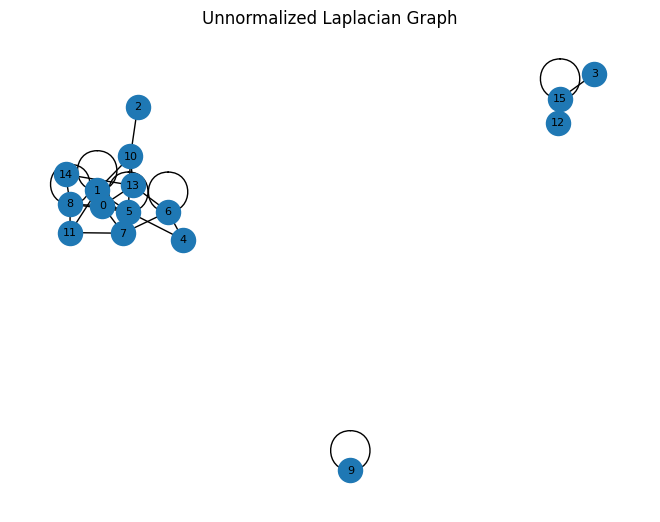

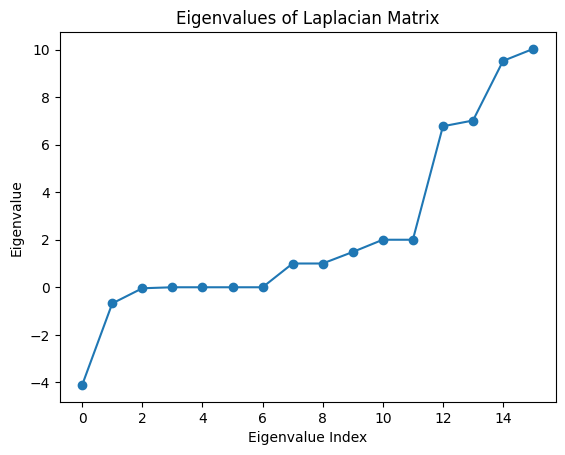

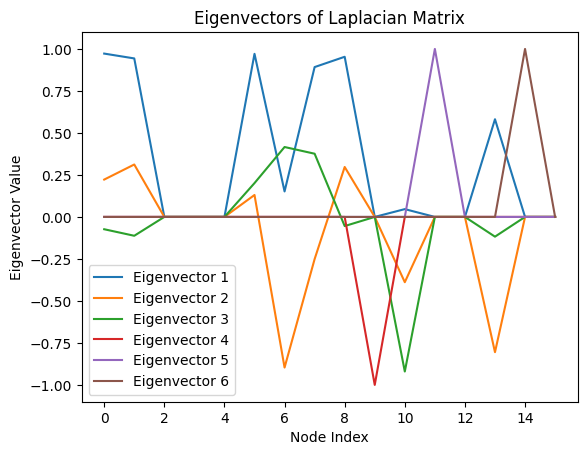

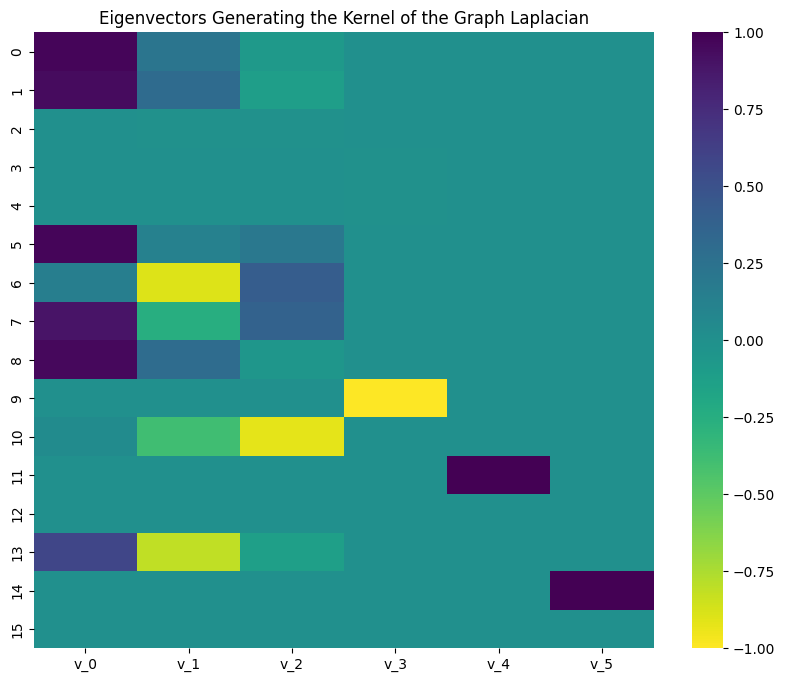

In [25]:
proj_df = pd.DataFrame(eigenvectors_norm)
proj_df.columns = ['v_' + str(c) for c in proj_df.columns]
print(proj_df.head())

import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph from the adjacency matrix
G = nx.Graph(adj_matrix.values)

# Plot the graph
pos = nx.spring_layout(G)  # Layout algorithm
nx.draw(G, pos, with_labels=True, node_size=300, font_size=8, font_color='black')

plt.title("Unnormalized Laplacian Graph")
plt.show()

# Visualize eigenvalues
plt.plot(eigenvalues, marker='o')
plt.title('Eigenvalues of Laplacian Matrix')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.show()

# Visualize eigenvectors
num_eigenvectors = eigenvectors_norm.shape[1]
for i in range(num_eigenvectors):
    plt.plot(eigenvectors_norm[:, i], label=f'Eigenvector {i+1}')

plt.title('Eigenvectors of Laplacian Matrix')
plt.xlabel('Node Index')
plt.ylabel('Eigenvector Value')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(proj_df, ax=ax, cmap='viridis_r')
ax.set(title='Eigenvectors Generating the Kernel of the Graph Laplacian');


## **Combined Strategy** - Spectral Clustering

Silhouette Score: 0.09044940722555475
Calinski-Harabasz Index: 3.896771774311657
Davies-Bouldin Index: 1.3314538960710298


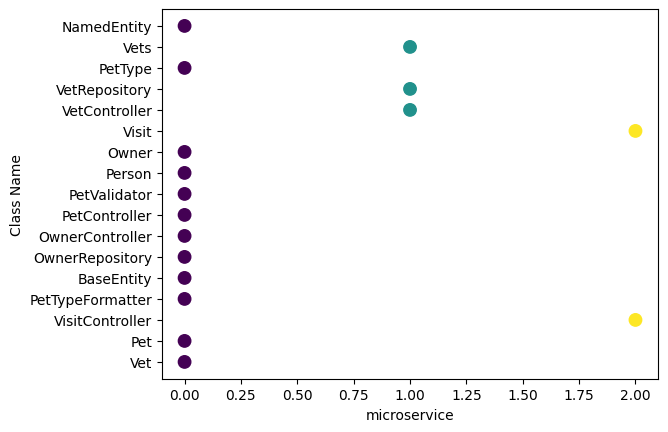

In [23]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(3, affinity='precomputed', n_init=800,
                        assign_labels='discretize')

combine_simlarity_df = pd.read_csv('/content/combie_similarity.csv')
combine_simlarity = pd.read_csv('/content/combie_similarity.csv',index_col=0).to_numpy()

cluster_labels = sc.fit_predict(combine_simlarity)

class_names = [i[0] for i in combine_simlarity_df.to_numpy()]

# Evaluate the clustering
scores(combine_simlarity, cluster_labels)
#ari = adjusted_rand_score(true_labels, predicted_labels)

# Plot the results
plt.scatter(cluster_labels,class_names, c=cluster_labels, cmap='viridis', s=80)
plt.xlabel('microservice')
plt.ylabel('Class Name')
plt.show()

Call similarity matrix calculation

In [24]:
incoming_calls = np.sum(adj_matrix, axis=1)

adj_matrix_np = adj_matrix.to_numpy()
#print(incoming_calls)
sim_matrix = np.zeros(adj_matrix_np.shape)

num_nodes = adj_matrix.shape[0]

# Add edges with weights
for i in range(num_nodes):
    for j in range(num_nodes):
      cj=ci=0
      if incoming_calls[i]!=0: cj = adj_matrix_np[i,j]/incoming_calls[i]
      if incoming_calls[j]!=0: ci = adj_matrix_np[j,i]/incoming_calls[j]
      sim_matrix[i,j]=sim_matrix[j,i] = (cj+ci)*0.5 if i!=j else cj
     # print(i,j,(adj_matrix_np[i,j],adj_matrix_np[j,i]),(incoming_calls[i],incoming_calls[j]),(ci,cj))

call_similarity_df = pd.DataFrame(sim_matrix, columns=adj_matrix.index, index=adj_matrix.index)

call_similarity_df.head(15)

,PetController,Pet,Visit,VetRepository,Person,Owner,OwnerController,BaseEntity,NamedEntity,Vet,VisitController,PetValidator,Vets,OwnerRepository,PetTypeFormatter,VetController
PetController,0.000000,0.2500,0.0,0.0,0.00,0.166667,0.000000,0.071429,0.1875,0.0,0.000000,0.000000,0.0,0.166667,0.000000,0.0
Pet,0.250000,0.1250,0.0,0.0,0.00,0.062500,0.000000,0.000000,0.0000,0.0,0.062500,0.062500,0.0,0.000000,0.000000,0.0
Visit,0.000000,0.0000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.0000,0.0,0.500000,0.000000,0.0,0.000000,0.000000,0.0
VetRepository,0.000000,0.0000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.5
Person,0.000000,0.0000,0.0,0.0,0.00,0.250000,0.250000,0.000000,0.0000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
Owner,0.166667,0.0625,0.0,0.0,0.25,0.500000,0.000000,0.285714,0.0625,0.0,0.083333,0.000000,0.0,0.000000,0.000000,0.0
OwnerController,0.000000,0.0000,0.0,0.0,0.25,0.000000,1.000000,0.071429,0.0000,0.0,0.000000,0.000000,0.0,0.166667,0.000000,0.0
BaseEntity,0.071429,0.0000,0.0,0.0,0.00,0.285714,0.071429,0.000000,0.0000,0.0,0.000000,0.071429,0.0,0.000000,0.000000,0.0
NamedEntity,0.187500,0.0000,0.0,0.0,0.00,0.062500,0.000000,0.000000,0.1250,0.0,0.000000,0.062500,0.0,0.000000,0.125000,0.0
Vet,0.000000,0.0000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.0000,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
